# Introduction

In this notebook, we analyse the oracles generated in **tc_br_orc_v2_gen** notebook:
 
 * TC_BR_volunteers
 * TC_BR_expert
 * TC_BR_volunteers_expert_union
 * TC_BR_volunteers_expert_intersec

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np

from sklearn.metrics import cohen_kappa_score

from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions

from matplotlib import pyplot as plt

In [2]:
volunteers_oracle = fd.Tc_BR_Oracles.read_oracle_volunteers_df()
expert_oracle = fd.Tc_BR_Oracles.read_oracle_expert_df()
print()

volunteers_expert_union_oracle = fd.Tc_BR_Oracles.read_oracle_expert_volunteers_union_df()
volunteers_expert_intersec_oracle = fd.Tc_BR_Oracles.read_oracle_expert_volunteers_intersec_df()
print()

bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()
print()

br_2_feature_matrix_final = fd.Feat_BR_Oracles.read_br_2_features_matrix_final_df()

OracleVolunteers.shape: (195, 91)
OracleExpert.shape: (195, 91)

OracleExpertVolunteers_UNION.shape: (195, 91)
OracleExpertVolunteers_INTERSEC.shape: (195, 91)

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)

BR_2_Features Matrix Final.shape: (91, 5)


# Cohen's Kappa - Test Cases x Bug Reports Trace Matrix

In the section bellow, we calculate the Cohen's kappa based on two matrices:

* the matrix of Test Cases x Bug Reports generated from the answers of the **expert**
* the matrix of Test Cases x Bug Reports generated from the answers of the **volunteers**

In [3]:
expert_answers = []
volunteers_answers = []

for idx,row in volunteers_oracle.iterrows():
    for col in volunteers_oracle.columns:
        volunteers_answers.append(volunteers_oracle.at[idx,col])
        expert_answers.append(expert_oracle.at[idx,col])

print("Expert Answers Length: {}".format(len(expert_answers)))
print("Volunteers Answers Length: {}".format(len(volunteers_answers)))

print("Cohen Kappa Score: {}".format(cohen_kappa_score(expert_answers, volunteers_answers)))

Expert Answers Length: 17745
Volunteers Answers Length: 17745
Cohen Kappa Score: 0.4638574418116276


We can observe that we have a weak inter-rater agreement level, because the kappa is between 0.40 and 0.59, we have only 15-35% of the data reliable. [Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/)

# Calculate Sparsity

In [4]:
print('volunteers_oracle sparcity: {:>40.2%}'.format(aux_functions.calculate_sparsity(volunteers_oracle)))
print('expert_oracle sparcity: {:>44.2%}'.format(aux_functions.calculate_sparsity(expert_oracle)))
print('volunteers_expert_union_oracle sparcity: {:>27.2%}'.format(aux_functions.calculate_sparsity(volunteers_expert_union_oracle)))
print('volunteers_expert_intersec_oracle sparcity: {:>24.2%}'.format(aux_functions.calculate_sparsity(volunteers_expert_intersec_oracle)))

volunteers_oracle sparcity:                                   93.21%
expert_oracle sparcity:                                       95.07%
volunteers_expert_union_oracle sparcity:                      91.18%
volunteers_expert_intersec_oracle sparcity:                   97.10%


# Analysis of Amount of Affected Test Cases by Features

Analysis of the amount of test cases that are directly affected by a bug report after made the traceability between bug reports and features in the empirical study. We analyse the amount of affected test cases using three different matrices: expert answers only, volunteers answers only and the result of expert and volunteers answers.

In [5]:
def calculate_affected_tcs_amount(row, col):
    amount_aff_tcs = 0
    for f_id in row[col].split(" "):
        if f_id != "":
            amount_aff_tcs = amount_aff_tcs + len(testcases[testcases.Feature_ID == int(f_id)])
    return amount_aff_tcs

br_2_feature_matrix_final['Amount_Aff_TCs_Exp'] = br_2_feature_matrix_final.apply(lambda row : calculate_affected_tcs_amount(row, 'Features_IDs_exp_m'), axis=1)
br_2_feature_matrix_final['Amount_Aff_TCs_Vol'] = br_2_feature_matrix_final.apply(lambda row : calculate_affected_tcs_amount(row, 'Features_IDs_vol_m'), axis=1)
br_2_feature_matrix_final['Amount_Aff_TCs_Exp_Vol_Union'] = br_2_feature_matrix_final.apply(lambda row : calculate_affected_tcs_amount(row, 'Features_IDs_exp_vol_union_m'), axis=1)
br_2_feature_matrix_final['Amount_Aff_TCs_Exp_Vol_Intersec'] = br_2_feature_matrix_final.apply(lambda row : calculate_affected_tcs_amount(row, 'Features_IDs_exp_vol_intersec_m'), axis=1)

#br_2_feature_matrix_final.head(100)

# Percentage of Positive and Negative Links

In [6]:
cols = ['Amount_Aff_TCs_Exp','Amount_Aff_TCs_Vol','Amount_Aff_TCs_Exp_Vol_Union','Amount_Aff_TCs_Exp_Vol_Intersec']
df = pd.DataFrame(columns=cols,
                  index=['PosLinks','NegLinks','TotalLinks','PercPosLinks','PercNegLinks'])

for col in cols:
    df.at['PosLinks',col] = br_2_feature_matrix_final[col].sum()
    df.at['NegLinks',col] = len(br_2_feature_matrix_final) * len(testcases) - df.at['PosLinks',col]
    df.at['TotalLinks',col] = df.at['PosLinks',col] + df.at['NegLinks',col]
    df.at['PercPosLinks',col] = round(float(df.at['PosLinks',col]/(df.at['PosLinks',col]+df.at['NegLinks',col])), 2)
    df.at['PercNegLinks',col] = round(float(df.at['NegLinks',col]/(df.at['PosLinks',col]+df.at['NegLinks',col])), 2)
    df.at['TotalPerc',col] = round(df.at['PercPosLinks',col] + df.at['PercNegLinks',col])

df.T.head(10)

,PosLinks,NegLinks,TotalLinks,PercPosLinks,PercNegLinks,TotalPerc
Amount_Aff_TCs_Exp,874,16871,17745,0.05,0.95,1
Amount_Aff_TCs_Vol,1205,16540,17745,0.07,0.93,1
Amount_Aff_TCs_Exp_Vol_Union,1565,16180,17745,0.09,0.91,1
Amount_Aff_TCs_Exp_Vol_Intersec,514,17231,17745,0.03,0.97,1


# Analysis of No Maching Answers

In [7]:
print(br_2_feature_matrix_final[(br_2_feature_matrix_final.Features_IDs_exp_m != br_2_feature_matrix_final.Features_IDs_vol_m) &
                                (br_2_feature_matrix_final.Features_IDs_exp_vol_intersec_m == "")].shape)

br_2_feature_matrix_final[(br_2_feature_matrix_final.Features_IDs_exp_m != br_2_feature_matrix_final.Features_IDs_vol_m)].head(90)

(39, 9)


,bug_title,Features_IDs_exp_m,Features_IDs_vol_m,Features_IDs_exp_vol_union_m,Features_IDs_exp_vol_intersec_m,Amount_Aff_TCs_Exp,Amount_Aff_TCs_Vol,Amount_Aff_TCs_Exp_Vol_Union,Amount_Aff_TCs_Exp_Vol_Intersec
Bug_Number,,,,,,,,,
1248268,"Unable to disable ""Recently bookmarked""",,4,4,,0,6,6,0
1267501,New Private Browsing start-page overflows off ...,3,,3,,22,0,22,0
1269485,New Private Browsing start-page has white/gray...,3,,3,,22,0,22,0
1271607,The new window's size is modified if the last ...,,1,1,,0,13,13,0
1277937,https has an underline instead of a strikethro...,1,,1,,13,0,13,0
1278388,Permafailing on the change to firefox50: brows...,,1,1,,0,13,13,0
1279140,awesomebar displaying incorrect text UI for co...,1,4 7,1 4 7,,13,12,25,0
1287687,Syncs happen every 90 seconds when stale devic...,,3,3,,0,22,22,0
1287748,Syncing away from lwtheme updates internal sta...,4,15,4 15,,6,18,24,0


# TC_BR Oracle Production

In 53/93 observations the answers don't match, that means 56.98% of the answers don't match totally. However, 17/53 or 32.07% of these answers do have some matching with the researchers answers, once they agree in at least one of the features attributed to the bug report.

Here we must to make a decision about which oracle must be considered to analyse our IR based models and how it must be produced. This decision has three options:
 
 1. We take the **intersection** of the answers. So we put 1 in the cells of the BR_TC trace matrix where the answers of the volunteers and the researcher have some degree of agreement;
 2. We take the **union** of the answers. So we put 1 in the cell of the BR_TC trace matrix where the volunteers or the researcher answered that there is a link;
 3. We make a **selection**, discarding the relations BR x Features where did not have agreement, considering only those that the volunteers and the researcher agreed, this would reduce the size of the oracle.






# Top Value For IR-based Models

We can observe that some bug reports are linked up to 31 test cases. So we must setup our IR-based models to return up to **31** test cases. In percentual terms, this represents 31/207 * 100 = 15%, this means the TOP values must have the value of **15**.

# Distribution Amount BRs by TCs

BRs x TCs Mean Amount - Exp Oracle: 4.5
BRs x TCs Mean Amount - Vol Oracle: 6.2
BRs x TCs Mean Amount - Exp-Vol Union Oracle: 8.0
BRs x TCs Mean Amount - Exp-Vol Intersec Oracle: 2.6


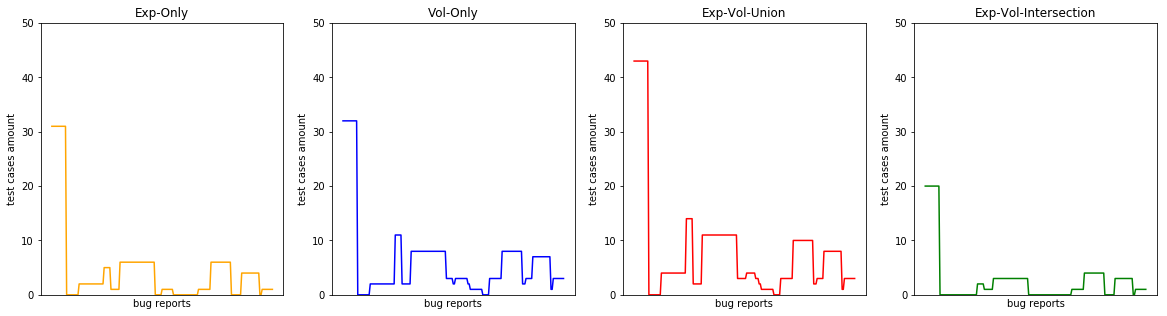

In [8]:
brs_expert = expert_oracle.index
tcs_amount_expert = expert_oracle.apply(lambda row : sum(row.values), axis=1)

brs_vol = volunteers_oracle.index
tcs_amount_vol = volunteers_oracle.apply(lambda row : sum(row.values), axis=1)

brs_exp_vol_union = volunteers_expert_union_oracle.index
tcs_amount_exp_vol_union = volunteers_expert_union_oracle.apply(lambda row : sum(row.values), axis=1)

brs_exp_vol_intersec = volunteers_expert_intersec_oracle.index
tcs_amount_exp_vol_intersec = volunteers_expert_intersec_oracle.apply(lambda row : sum(row.values), axis=1)

f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,5))

ax1.set_title('Exp-Only')
ax1.plot(brs_expert, tcs_amount_expert, color='orange')
ax1.set(xlabel='bug reports', ylabel='test cases amount')
ax1.set_ylim([0, 50])
ax1.xaxis.set_ticks([])

ax2.set_title('Vol-Only')
ax2.plot(brs_vol, tcs_amount_vol, color='blue')
ax2.set(xlabel='bug reports', ylabel='test cases amount')
ax2.set_ylim([0, 50])
ax2.xaxis.set_ticks([])

ax3.set_title('Exp-Vol-Union')
ax3.plot(brs_exp_vol_union, tcs_amount_exp_vol_union, color='red')
ax3.set(xlabel='bug reports', ylabel='test cases amount')
ax3.set_ylim([0, 50])
ax3.xaxis.set_ticks([])

ax4.set_title('Exp-Vol-Intersection')
ax4.plot(brs_exp_vol_intersec, tcs_amount_exp_vol_intersec, color='green')
ax4.set(xlabel='bug reports', ylabel='test cases amount')
ax4.set_ylim([0, 50])
ax4.xaxis.set_ticks([])

print("BRs x TCs Mean Amount - Exp Oracle: {:2.2}".format(np.mean(tcs_amount_expert)))
print("BRs x TCs Mean Amount - Vol Oracle: {:2.2}".format(np.mean(tcs_amount_vol)))
print("BRs x TCs Mean Amount - Exp-Vol Union Oracle: {:2.2}".format(np.mean(tcs_amount_exp_vol_union)))
print("BRs x TCs Mean Amount - Exp-Vol Intersec Oracle: {:2.2}".format(np.mean(tcs_amount_exp_vol_intersec)))

# Analysis of Histograms of Test Cases Amounts

(array([111.,  53.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,  13.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

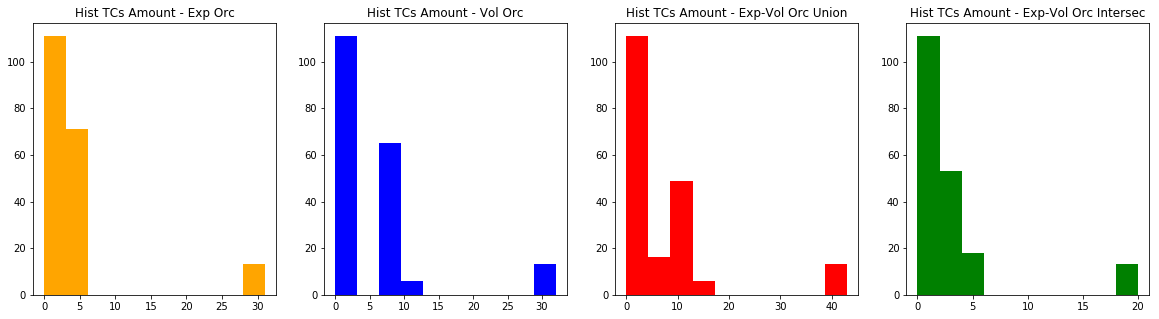

In [9]:
f2, (ax4,ax5,ax6,ax7) = plt.subplots(1, 4, figsize=(20,5))

ax4.set_title('Hist TCs Amount - Exp Orc')
ax4.hist(tcs_amount_expert, color='orange')

ax5.set_title('Hist TCs Amount - Vol Orc')
ax5.hist(tcs_amount_vol, color='blue')

ax6.set_title('Hist TCs Amount - Exp-Vol Orc Union')
ax6.hist(tcs_amount_exp_vol_union, color='red')

ax7.set_title('Hist TCs Amount - Exp-Vol Orc Intersec')
ax7.hist(tcs_amount_exp_vol_intersec, color='green')